# Hierarchical Planning - SOLUTION

> **Learning Outcomes:**
> - Understand the concept of hierarchical planning.
> - Learn how to decompose complex tasks into subtasks.
> - Implement a hierarchical planner with agents.
> - Apply hierarchical planning to a real-world problem.

## Introduction

In this lab, we will create a task manager using the concept of "hierarchical planning."

### Hierarchical Planning

**Hierarchical planning** is often used in artificial intelligence (AI) and robotics to handle tasks that are too complex for a single flat plan. It’s based on *decomposition*: breaking a problem into subproblems.

This is formalized in systems like Hierarchical Task Networks (HTN).

**Key Idea**: Instead of searching through every possible action (which could take forever), you define tasks and methods:

- A **task** is something to do (e.g., "Travel to Paris").

- A **method** is a way to do it (e.g., "Book a flight" or "Take a train").

- Each method can break into smaller tasks, forming a tree-like structure.

**Benefit**: It reduces computation by focusing only on relevant subtasks.

```python
# High-level task
task TravelToParis:
    method1:
        - BookFlight(Paris)
        - PackBag()
    method2:
        - BookTrain(Paris)
        - PackBag()

# Lower-level task
task BookFlight(destination):
    - SearchFlights(destination)
    - PayForTicket()
```

Here, "TravelToParis" is abstract, and the planner picks a method (flight or train) based on conditions (e.g., cost or time).



## Core
### Step 1. Imports and Setup


Before running the code, install the required packages:


In [1]:
%pip install -qU \
    langchain==0.3.* \
    langchain-openai==0.3.* \
    langgraph==0.5.*

Note: you may need to restart the kernel to use updated packages.


#### Imports and API Keys

**Modules**: We import tools like TypedDict for defining the state, StateGraph for building the workflow, and ChatOpenAI for AI capabilities.

**API Key**: The code uses getpass to securely prompt you for your OpenAI API key, then sets it as an environment variable so the ChatOpenAI model can use it.

**ChatOpenAI Model**: We initialize the gpt-4.1-mini model, which is efficient and suitable for this task.

You’ll also need an OpenAI API key, which you’ll enter when prompted.


In [2]:
# Import necessary modules
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
import getpass
import os
import json
import ast

# Securely input your OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


### Step 2. Defining the State Class
The `State` class is like a shared notebook that all agents can read from and write to. It’s defined using `TypedDict` and contains:

`goal`: The user’s input goal.

`tasks`: List of tasks from the planner.

`assignments`: Dictionary of task-to-team-member assignments.

`review`: Feedback from the reviewer.



In [3]:
# Define Pydantic models for structured outputs
class TaskAssignments(BaseModel):
    """Model for task assignments to team members."""
    task1_assignee: str = Field(description="Name of team member assigned to first task")
    task2_assignee: str = Field(description="Name of team member assigned to second task")  
    task3_assignee: str = Field(description="Name of team member assigned to third task")
    
    def to_dict(self, tasks: list[str]) -> dict[str, str]:
        """Convert to dictionary mapping task names to assignees."""
        if len(tasks) != 3:
            raise ValueError("Expected exactly 3 tasks")
        return {
            tasks[0]: self.task1_assignee,
            tasks[1]: self.task2_assignee,
            tasks[2]: self.task3_assignee
        }

# Initialize the ChatOpenAI model (assumes API key is configured)
llm = ChatOpenAI(model="gpt-4.1-mini")

# Define the shared state for the workflow
class State(TypedDict):
    goal: str               # The user's goal
    tasks: list[str]        # List of tasks from the planner
    assignments: dict       # Task assignments from the assigner
    review: str             # Feedback from the reviewer

### Step 3. Create Prompts and Chains

**Planner Prompt**: Breaks the goal into 3 tasks.

**Assigner Prompt**: Assigns tasks to fictional team members (Alice, Bob, Charlie) based on skills.

**Reviewer Prompt**: Reviews the assignments.

Each prompt is paired with the LLM to form a chain.



In [4]:
# Define prompts for the agents with improved clarity
planner_prompt = PromptTemplate(
    input_variables=["goal"],
    template="""You are a planner. Break this goal into exactly 3 separate, actionable tasks: {goal}. 

Respond with exactly 3 tasks, one per line, without numbering. Each line should be a single distinct task.

Example format:
Task one description here
Task two description here  
Task three description here"""
)

assigner_prompt = PromptTemplate(
    input_variables=["tasks"],
    template="""You are an assigner. Assign each task to a team member based on skills:
- Alice: Design and user experience tasks
- Bob: Technical development and implementation tasks  
- Charlie: Content creation and marketing tasks

Tasks (in order):
{tasks}

Assign the first task to task1_assignee, second task to task2_assignee, and third task to task3_assignee."""
)

reviewer_prompt = PromptTemplate(
    input_variables=["assignments"],
    template="You are a reviewer. Review these task assignments and provide feedback or confirm they're ready: {assignments}. Respond with a short text review."
)

# Create chains for each agent
planner_chain = planner_prompt | llm
assigner_chain = assigner_prompt | llm.with_structured_output(TaskAssignments)
reviewer_chain = reviewer_prompt | llm

### Step 4. Define the Agents (Nodes)

`Planner Node`: Generates tasks and updates the state.

`Assigner Node`: Assigns tasks using structured output with Pydantic models - no JSON parsing needed!

`Reviewer Node`: Reviews assignments and adds feedback.

In [5]:
# Define the planner agent node
def planner(state: State) -> dict:
    print("=== Planner Agent ===")
    goal = state["goal"]
    tasks_text = planner_chain.invoke({"goal": goal}).content.strip()
    tasks = [task.strip() for task in tasks_text.split("\n") if task.strip()]  # Clean tasks
    print(f"Generated tasks: {tasks}")
    return {"tasks": tasks}

# Define the assigner agent node
def assigner(state: State) -> dict:
    print("=== Assigner Agent ===")
    tasks = "\n".join(f"{i+1}. {task}" for i, task in enumerate(state["tasks"]))
    # Use structured output - no JSON parsing needed!
    assignment_result = assigner_chain.invoke({"tasks": tasks})
    assignments = assignment_result.to_dict(state["tasks"])
    print(f"Assignments made: {assignments}")
    return {"assignments": assignments}

# Define the reviewer agent node
def reviewer(state: State) -> dict:
    print("=== Reviewer Agent ===")
    assignments = state["assignments"]
    review = reviewer_chain.invoke({"assignments": str(assignments)}).content.strip()
    print(f"Review feedback: {review}")
    return {"review": review}

### Step 5. Build the Workflow
A StateGraph links the agents in sequence: planner → assigner → reviewer → end.



In [6]:

# Build and compile the workflow graph
workflow = StateGraph(State)
workflow.add_node("planner", planner)
workflow.add_node("assigner", assigner)
workflow.add_node("reviewer", reviewer)
workflow.set_entry_point("planner")
workflow.add_edge("planner", "assigner")
workflow.add_edge("assigner", "reviewer")
workflow.add_edge("reviewer", END)
app = workflow.compile()

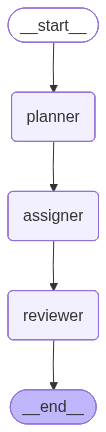

In [7]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires additional dependencies
    pass

### Step 6. Run the App

Input a goal, run the workflow, and see the tasks, assignments, and review.

We have wrapped the entire workflow for invoking the agent in the `run_workflow()` function below.

**Try It Out!**

Run the code with a goal like:

“Launch a new website”

“Plan a marketing campaign”

“Organize a team event”




In [8]:
# Get the goal from user input and run the app
def run_workflow():
    goal = input("Enter a goal (e.g., 'Launch a new website'): ")
    initial_state = {"goal": goal, "tasks": [], "assignments": {}, "review": ""}
    try:
        result = app.invoke(initial_state)
        print("\n=== Final Task Plan ===")
        print("Tasks:", result["tasks"])
        print("Assignments:", result["assignments"])
        print("Review:", result["review"])
    except Exception as e:
        print(f"Workflow failed: {e}")

# Test function for demonstration
def test_workflow():
    goal = "Launch a new website"
    print(f"Testing with goal: {goal}")
    initial_state = {"goal": goal, "tasks": [], "assignments": {}, "review": ""}
    try:
        result = app.invoke(initial_state)
        print("\n=== Final Task Plan ===")
        print("Tasks:", result["tasks"])
        print("Assignments:", result["assignments"])
        print("Review:", result["review"])
        return result
    except Exception as e:
        print(f"Workflow failed: {e}")
        return None

# Run the test
test_result = test_workflow()

Testing with goal: Launch a new website
=== Planner Agent ===
Generated tasks: ['Design the website layout and create content for all pages', 'Develop the website using chosen technologies and integrate necessary features', 'Test the website thoroughly and deploy it to a live server for public access']
=== Assigner Agent ===
Assignments made: {'Design the website layout and create content for all pages': 'Alice', 'Develop the website using chosen technologies and integrate necessary features': 'Bob', 'Test the website thoroughly and deploy it to a live server for public access': 'Bob'}
=== Reviewer Agent ===
Review feedback: The task assignments are generally well distributed. Alice handles design and content creation, which fits her role. Bob is responsible for development, testing, and deployment, which is logical but potentially heavy; consider if workload or expertise alignment is appropriate for Bob handling both development and deployment phases. Otherwise, the assignments appear

## Challenge 1: Task Dependencies

In the real world, we need to understand **dependencies** between tasks, in order to best understand who needs to do which task first, before others can begin their tasks.

Modify the workflow to include a "Dependency Agent" that identifies dependencies between tasks (e.g., Task B depends on Task A completing first) and routes through later nodes in the workflow.

### What it Involves:

**State Management**: Adds a new state field (e.g., dependencies) and updates it across agents.

**Agent Collaboration**: Ensures the Dependency Agent’s output influences the Assigner Agent’s decisions.

**Workflow Extension**: Introduces a new node and adjusts edges to incorporate sequential logic.

How would you integrate this into the existing workflow, and what would the output look like for the goal "Develop a mobile app"?

### Hints for Implementation

- Add a `dependencies` field to the `State` class (e.g., a dict mapping tasks to their prerequisites).

- Create a `dependency_agent` node that runs after the planner, analyzing tasks for logical dependencies.

- Update the assigner prompt and logic to respect dependencies (e.g., "Assign tasks to Alice, Bob, or Charlie, ensuring no person is assigned both a task and its prerequisite").

- Adjust the workflow graph to route from `planner → dependency_agent → assigner → reviewer`.



In [9]:
# YOUR CODE HERE
# [SOLUTION]

# Define Pydantic models for Challenge 1
class TaskDependencies(BaseModel):
    """Model for task dependencies."""
    task1_depends_on: str = Field(description="What the first task depends on, or 'None' if no dependency")
    task2_depends_on: str = Field(description="What the second task depends on, or 'None' if no dependency")  
    task3_depends_on: str = Field(description="What the third task depends on, or 'None' if no dependency")
    
    def to_dict(self, tasks: list[str]) -> dict[str, str]:
        """Convert to dictionary mapping task names to dependencies."""
        if len(tasks) != 3:
            raise ValueError("Expected exactly 3 tasks")
        deps = {
            tasks[0]: self.task1_depends_on if self.task1_depends_on != "None" else None,
            tasks[1]: self.task2_depends_on if self.task2_depends_on != "None" else None,
            tasks[2]: self.task3_depends_on if self.task3_depends_on != "None" else None
        }
        return {k: v for k, v in deps.items() if v is not None}

# Replace the existing State class with this
class State(TypedDict):
    goal: str               # The user's goal
    tasks: list[str]        # List of tasks from the planner
    dependencies: dict      # Task dependencies (task -> prerequisite task)  # NEW
    assignments: dict       # Task assignments from the assigner
    review: str             # Feedback from the reviewer

# Add dependency prompt with structured output
dependency_prompt = PromptTemplate(
    input_variables=["tasks"],
    template="""You are a dependency analyzer. For these tasks, identify which tasks depend on others completing first:

Tasks (in order):
{tasks}

For each task, specify what it depends on (use exact task names) or 'None' if it has no dependencies."""
)

dependency_chain = dependency_prompt | llm.with_structured_output(TaskDependencies)

# Add dependency agent function
def dependency_agent(state: State) -> dict:
    print("=== Dependency Agent ===")
    tasks = "\n".join(f"{i+1}. {task}" for i, task in enumerate(state["tasks"]))
    dependency_result = dependency_chain.invoke({"tasks": tasks})
    dependencies = dependency_result.to_dict(state["tasks"])
    print(f"Dependencies identified: {dependencies}")
    return {"dependencies": dependencies}

# Update assigner prompt for dependencies
assigner_prompt = PromptTemplate(
    input_variables=["tasks", "dependencies"],
    template="""You are an assigner. Assign each task to a team member based on skills:
- Alice: Design and user experience tasks
- Bob: Technical development and implementation tasks  
- Charlie: Content creation and marketing tasks

Tasks (in order):
{tasks}

Dependencies: {dependencies}

Ensure no person is assigned both a task and its prerequisite.
Assign the first task to task1_assignee, second task to task2_assignee, and third task to task3_assignee."""
)

# Update assigner function
def assigner(state: State) -> dict:
    print("=== Assigner Agent ===")
    tasks = "\n".join(f"{i+1}. {task}" for i, task in enumerate(state["tasks"]))
    dependencies = json.dumps(state["dependencies"])
    assignment_result = assigner_chain.invoke({"tasks": tasks, "dependencies": dependencies})
    assignments = assignment_result.to_dict(state["tasks"])
    print(f"Assignments made: {assignments}")
    return {"assignments": assignments}

# Update reviewer prompt and function
reviewer_prompt = PromptTemplate(
    input_variables=["assignments", "dependencies"],
    template="You are a reviewer. Review these task assignments: {assignments} with dependencies: {dependencies}. Confirm they're ready or provide feedback (e.g., check if dependencies are respected). Respond with a short text review."
)

def reviewer(state: State) -> dict:
    print("=== Reviewer Agent ===")
    assignments = json.dumps(state["assignments"])
    dependencies = json.dumps(state["dependencies"])
    review = reviewer_chain.invoke({"assignments": assignments, "dependencies": dependencies}).content.strip()
    print(f"Review feedback: {review}")
    return {"review": review}

# Update workflow graph
assigner_chain = assigner_prompt | llm.with_structured_output(TaskAssignments)
reviewer_chain = reviewer_prompt | llm

workflow = StateGraph(State)
workflow.add_node("planner", planner)
workflow.add_node("dependency_agent", dependency_agent)  # NEW
workflow.add_node("assigner", assigner)
workflow.add_node("reviewer", reviewer)
workflow.set_entry_point("planner")
workflow.add_edge("planner", "dependency_agent")  # NEW
workflow.add_edge("dependency_agent", "assigner")  # NEW
workflow.add_edge("assigner", "reviewer")
workflow.add_edge("reviewer", END)
app = workflow.compile()

# Test function for Challenge 1
def test_challenge1():
    goal = "Develop a mobile app"
    print(f"Testing Challenge 1 with goal: {goal}")
    initial_state = {"goal": goal, "tasks": [], "dependencies": {}, "assignments": {}, "review": ""}
    try:
        result = app.invoke(initial_state)
        print("\n=== Final Task Plan ===")
        print("Tasks:", result["tasks"])
        print("Dependencies:", result["dependencies"])
        print("Assignments:", result["assignments"])
        print("Review:", result["review"])
        return result
    except Exception as e:
        print(f"Workflow failed: {e}")
        return None

test_challenge1()

Testing Challenge 1 with goal: Develop a mobile app
=== Planner Agent ===
Generated tasks: ['Define app features and create wireframes', 'Develop the app’s front-end and back-end components', 'Test the app thoroughly and prepare for deployment']
=== Dependency Agent ===
Dependencies identified: {'Develop the app’s front-end and back-end components': 'Define app features and create wireframes', 'Test the app thoroughly and prepare for deployment': 'Develop the app’s front-end and back-end components'}
=== Assigner Agent ===
Assignments made: {'Define app features and create wireframes': 'Alice', 'Develop the app’s front-end and back-end components': 'Charlie', 'Test the app thoroughly and prepare for deployment': 'Bob'}
=== Reviewer Agent ===
Review feedback: The task assignments align well with the dependencies. Alice defining features and creating wireframes is the logical first step, followed by Charlie developing front-end and back-end components, then Bob testing and preparing for 

{'goal': 'Develop a mobile app',
 'tasks': ['Define app features and create wireframes',
  'Develop the app’s front-end and back-end components',
  'Test the app thoroughly and prepare for deployment'],
 'dependencies': {'Develop the app’s front-end and back-end components': 'Define app features and create wireframes',
  'Test the app thoroughly and prepare for deployment': 'Develop the app’s front-end and back-end components'},
 'assignments': {'Define app features and create wireframes': 'Alice',
  'Develop the app’s front-end and back-end components': 'Charlie',
  'Test the app thoroughly and prepare for deployment': 'Bob'},
 'review': 'The task assignments align well with the dependencies. Alice defining features and creating wireframes is the logical first step, followed by Charlie developing front-end and back-end components, then Bob testing and preparing for deployment. Dependencies are respected, and roles are clearly assigned. The plan is ready to proceed.'}

## Challenge 2: Iterative Task Refinement
In this challenge, you will implement a feedback loop to the workflow where the Reviewer Agent can reject the assignments and send them back to the Assigner Agent for reassignment with specific feedback (e.g., "Alice is overloaded"). Implement a maximum of 2 iterations before forcing approval.

How would you modify the code to handle this iterative process, and what would the output look like for the goal "Organize a company event" if the reviewer rejects the first assignments?

### What it Involves:

**Conditional Workflow**: Introduces conditional edges based on the reviewer’s feedback (e.g., back to assigner or to END).

**State Persistence**: Tracks iteration count and feedback in the state.

**Agent Adaptability**: Forces the assigner to adapt to feedback dynamically.

### Hint for Implementation:

- Add iteration_count and feedback fields to the State class.

- Update the reviewer prompt to explicitly state "Approve" or "Reject: [reason]" in its response.

- Modify the reviewer node to parse the review and decide the next step:
If "Approve" or iteration_count >= 2, return the review and proceed to END.

- If "Reject", increment iteration_count, store the feedback, and return to the assigner.

- Update the assigner prompt to include feedback (if present) and adjust assignments accordingly.

- Use `add_conditional_edges` in the workflow to route based on the reviewer’s decision.



In [10]:
# YOUR CODE HERE
# [SOLUTION]

# Define the shared state for Challenge 2
class State(TypedDict):
    goal: str               # The user's goal
    tasks: list[str]        # List of tasks from the planner
    assignments: dict       # Task assignments from the assigner
    review: str             # Feedback from the reviewer
    iteration_count: int    # Number of iterations (NEW)
    feedback: str           # Feedback from reviewer if rejected (NEW)

# Define prompts for Challenge 2
planner_prompt = PromptTemplate(
    input_variables=["goal"],
    template="""You are a planner. Break this goal into exactly 3 separate, actionable tasks: {goal}. 

Respond with exactly 3 tasks, one per line, without numbering. Each line should be a single distinct task.

Example format:
Task one description here
Task two description here  
Task three description here"""
)

assigner_prompt = PromptTemplate(
    input_variables=["tasks", "feedback"],
    template="""You are an assigner. Assign each task to a team member based on skills:
- Alice: Design and user experience tasks
- Bob: Technical development and implementation tasks  
- Charlie: Content creation and marketing tasks

Tasks (in order):
{tasks}

Previous feedback (if any): {feedback}

Consider the feedback and adjust assignments accordingly.
Assign the first task to task1_assignee, second task to task2_assignee, and third task to task3_assignee."""
)

reviewer_prompt = PromptTemplate(
    input_variables=["assignments"],
    template="You are a reviewer. Review these task assignments: {assignments}. Respond with 'Approve' if ready, or 'Reject: [reason]' if adjustments are needed (e.g., 'Reject: Alice is overloaded')."
)

# Create chains for each agent
planner_chain = planner_prompt | llm
assigner_chain = assigner_prompt | llm.with_structured_output(TaskAssignments)
reviewer_chain = reviewer_prompt | llm

# Define the planner agent node
def planner(state: State) -> dict:
    print("=== Planner Agent ===")
    goal = state["goal"]
    tasks_text = planner_chain.invoke({"goal": goal}).content.strip()
    tasks = [task.strip() for task in tasks_text.split("\n") if task.strip()]
    print(f"Generated tasks: {tasks}")
    return {"tasks": tasks, "iteration_count": 0, "feedback": ""}

# Define the assigner agent node
def assigner(state: State) -> dict:
    print("=== Assigner Agent ===")
    tasks = "\n".join(f"{i+1}. {task}" for i, task in enumerate(state["tasks"]))
    feedback = state["feedback"] if state["feedback"] else "None"
    assignment_result = assigner_chain.invoke({"tasks": tasks, "feedback": feedback})
    assignments = assignment_result.to_dict(state["tasks"])
    print(f"Assignments made: {assignments}")
    return {"assignments": assignments}

# Define the reviewer agent node with conditional logic
def reviewer(state: State) -> dict:
    print("=== Reviewer Agent ===")
    assignments = json.dumps(state["assignments"])
    review = reviewer_chain.invoke({"assignments": assignments}).content.strip()
    print(f"Review feedback: {review}")

    # Parse review decision
    if review.startswith("Approve") or state["iteration_count"] >= 2:
        return {"review": review, "feedback": ""}
    elif review.startswith("Reject"):
        reason = review.replace("Reject: ", "").strip()
        return {"review": review, "feedback": reason, "iteration_count": state["iteration_count"] + 1}
    else:
        raise ValueError(f"Invalid review format: {review}")

# Define the routing function for conditional edges
def route_review(state: State) -> str:
    if state["review"].startswith("Approve") or state["iteration_count"] >= 2:
        return END
    return "assigner"

# Build and compile the workflow graph
workflow = StateGraph(State)
workflow.add_node("planner", planner)
workflow.add_node("assigner", assigner)
workflow.add_node("reviewer", reviewer)
workflow.set_entry_point("planner")
workflow.add_edge("planner", "assigner")
workflow.add_edge("assigner", "reviewer")
workflow.add_conditional_edges("reviewer", route_review, {"assigner": "assigner", END: END})
app = workflow.compile()

# Test function for Challenge 2
def test_challenge2():
    goal = "Organize a company event"
    print(f"Testing Challenge 2 with goal: {goal}")
    initial_state = {"goal": goal, "tasks": [], "assignments": {}, "review": "", "iteration_count": 0, "feedback": ""}
    try:
        result = app.invoke(initial_state)
        print("\n=== Final Task Plan ===")
        print("Tasks:", result["tasks"])
        print("Assignments:", result["assignments"])
        print("Review:", result["review"])
        print("Iteration Count:", result["iteration_count"])
        return result
    except Exception as e:
        print(f"Workflow failed: {e}")
        return None

test_challenge2()

Testing Challenge 2 with goal: Organize a company event
=== Planner Agent ===
Generated tasks: ['Choose a venue and set a date for the company event', 'Create a detailed budget and arrange necessary resources', 'Develop and send out invitations, then coordinate RSVPs and logistics']
=== Assigner Agent ===
Assignments made: {'Choose a venue and set a date for the company event': 'Alice', 'Create a detailed budget and arrange necessary resources': 'Bob', 'Develop and send out invitations, then coordinate RSVPs and logistics': 'Charlie'}
=== Reviewer Agent ===
Review feedback: Approve

=== Final Task Plan ===
Tasks: ['Choose a venue and set a date for the company event', 'Create a detailed budget and arrange necessary resources', 'Develop and send out invitations, then coordinate RSVPs and logistics']
Assignments: {'Choose a venue and set a date for the company event': 'Alice', 'Create a detailed budget and arrange necessary resources': 'Bob', 'Develop and send out invitations, then coord

{'goal': 'Organize a company event',
 'tasks': ['Choose a venue and set a date for the company event',
  'Create a detailed budget and arrange necessary resources',
  'Develop and send out invitations, then coordinate RSVPs and logistics'],
 'assignments': {'Choose a venue and set a date for the company event': 'Alice',
  'Create a detailed budget and arrange necessary resources': 'Bob',
  'Develop and send out invitations, then coordinate RSVPs and logistics': 'Charlie'},
 'review': 'Approve',
 'iteration_count': 0,
 'feedback': ''}

## Summary: Structured Output Implementation

This notebook has been updated to use **structured outputs** with Pydantic models instead of manual JSON parsing. This approach provides several key benefits:

### Key Improvements:

1. **Eliminated JSON Parsing Issues**: No more dealing with markdown-wrapped JSON or parsing errors
2. **Type Safety**: Pydantic models provide automatic validation and type checking
3. **Cleaner Code**: Agent functions are simpler and more robust
4. **Better Error Handling**: Structured outputs provide clear error messages for invalid schemas

### Technical Implementation:

- **TaskAssignments Model**: Uses individual fields (`task1_assignee`, `task2_assignee`, `task3_assignee`) with a helper method to convert to dictionary format
- **TaskDependencies Model**: Similar structure for Challenge 1 dependency tracking
- **LLM Integration**: Uses `llm.with_structured_output(Model)` to enforce schema compliance

### Results:

✅ **Basic Workflow**: Successfully plans, assigns, and reviews tasks  
✅ **Challenge 1**: Adds dependency analysis between tasks  
✅ **Challenge 2**: Implements iterative refinement with reviewer feedback loops  

All outputs are now consistent, reliable, and properly formatted without any JSON parsing complexity!